# Petri Net Discovery: Sequencial & Loop & Parallel Workflow Patterns

## Step 1: Setup

In [1]:
import pandas as pd
import pm4py
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer

## Step 2: Load Event Log from CSV

In [2]:
df = pd.read_csv("2d_toy_log_day11-sequential-loop-parallel-choice.csv", sep=';',parse_dates=["timestamp"])
df

,timestamp,stress,location,event_type,lifecycle,bout_type,action,day,stress_qual,detailed_event_type,simple_event_type,report_case_id,simpler_event_type
0,2025-11-05 08:52:00,30.0,home,self-report,NaN,NaN,NaN,11/05/2025,high,stress_report_high,self-report_high,12,self-report_high
1,2025-11-05 11:34:00,NaN,other,physical_activity,START,LIGHT_PA,NaN,11/05/2025,NaN,START_LIGHT_PA,physical_activity_,13,physical_activity_START
2,2025-11-05 11:35:00,NaN,other,physical_activity,END,LIGHT_PA,NaN,11/05/2025,NaN,END_LIGHT_PA,physical_activity_,13,physical_activity_END
3,2025-11-05 11:54:00,40.0,other,self-report,NaN,NaN,NaN,11/05/2025,low,stress_report_low,self-report_low,13,self-report_low
4,2025-11-05 13:24:00,NaN,home,physical_activity,START,LIGHT_PA,NaN,11/05/2025,NaN,START_LIGHT_PA,physical_activity_,16,physical_activity_START
5,2025-11-05 13:29:00,NaN,invalid,physical_activity,END,LIGHT_PA,NaN,11/05/2025,NaN,END_LIGHT_PA,physical_activity_,16,physical_activity_END
6,2025-11-05 13:48:00,NaN,other,physical_activity,START,LIGHT_PA,NaN,11/05/2025,NaN,START_LIGHT_PA,physical_activity_,16,physical_activity_START
7,2025-11-05 14:08:00,NaN,other,physical_activity,END,LIGHT_PA,NaN,11/05/2025,NaN,END_LIGHT_PA,physical_activity_,16,physical_activity_END
8,2025-11-05 14:55:00,30.0,home,self-report,NaN,NaN,NaN,11/05/2025,low,stress_report_low,self-report_low,16,self-report_low
9,2025-11-05 20:53:00,NaN,in_transit,physical_activity,START,LIGHT_PA,NaN,11/05/2025,NaN,START_LIGHT_PA,physical_activity_,80,physical_activity_START


## Step 3: Prepare the Event Log
PM4Py expects specific column names. Let's rename them and sort the log by time within each case.

In [3]:
# Rename columns to PM4Py convention
df = df.rename(columns={
    "timestamp": "time:timestamp",
    "report_case_id": "case:concept:name",
    "simpler_event_type": "concept:name"
})

# Sort by case and time
df = dataframe_utils.convert_timestamp_columns_in_df(df)
df = df.sort_values(by=["case:concept:name", "time:timestamp"])
#df['case:concept:name'] = df['case:concept:name'].dt.strftime('%Y-%m-%d')

# Ensure concept:name is string type
df['concept:name'] = df['concept:name'].astype(str)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   time:timestamp       12 non-null     datetime64[ns, UTC]
 1   stress               4 non-null      float64            
 2   location             12 non-null     object             
 3   event_type           12 non-null     object             
 4   lifecycle            8 non-null      object             
 5   bout_type            8 non-null      object             
 6   action               0 non-null      float64            
 7   day                  12 non-null     datetime64[ns, UTC]
 8   stress_qual          4 non-null      object             
 9   detailed_event_type  12 non-null     object             
 10  simple_event_type    12 non-null     object             
 11  case:concept:name    12 non-null     int64              
 12  concept:name         12 

## Step 4: Convert to PM4Py Event Log

In [4]:
from pm4py.objects.conversion.log import converter as log_converter

event_log = log_converter.apply(df, variant=log_converter.Variants.TO_EVENT_LOG)

## Step 5: Discover the Process Tree Using Inductive Miner

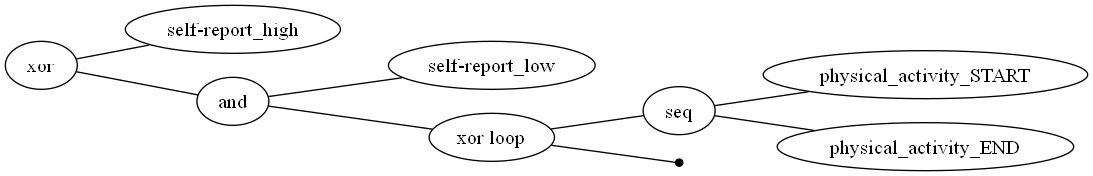

In [5]:
## Discover Process Model
# First get the process tree
process_tree = inductive_miner.apply(event_log)

# Visualize Process Tree
from pm4py.visualization.process_tree import visualizer as pt_visualizer
gviz_pt = pt_visualizer.apply(process_tree)
pt_visualizer.view(gviz_pt)



## Step 6: Converting to Petri Net

In [6]:
# Convert process tree to Petri net
from pm4py.objects.conversion.process_tree import converter as pt_converter
net, initial_marking, final_marking = pt_converter.apply(process_tree)



## Step 7: Visualizing the Petri Net

Simple Petri Net 

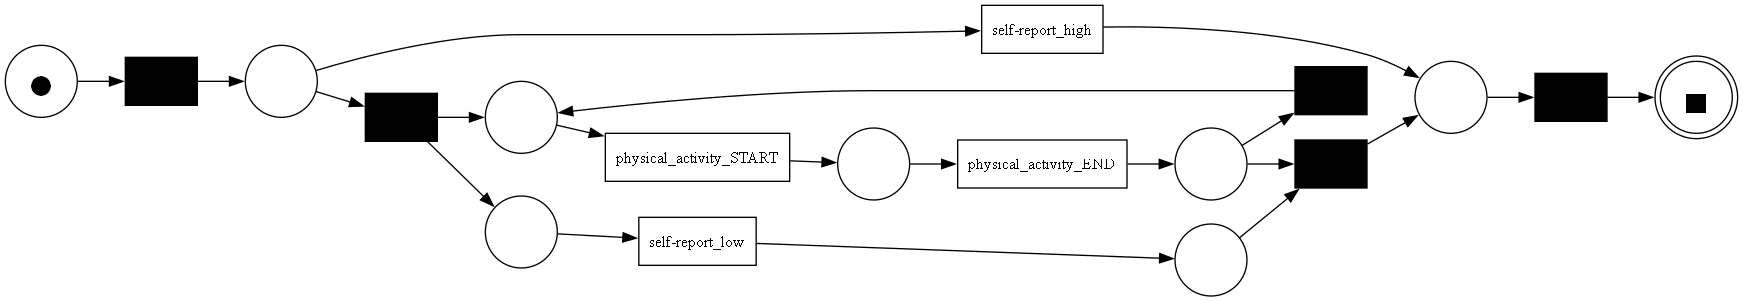

In [14]:
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                          log=event_log)
pn_visualizer.view(gviz)

Petri Net with frequency statistics

replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

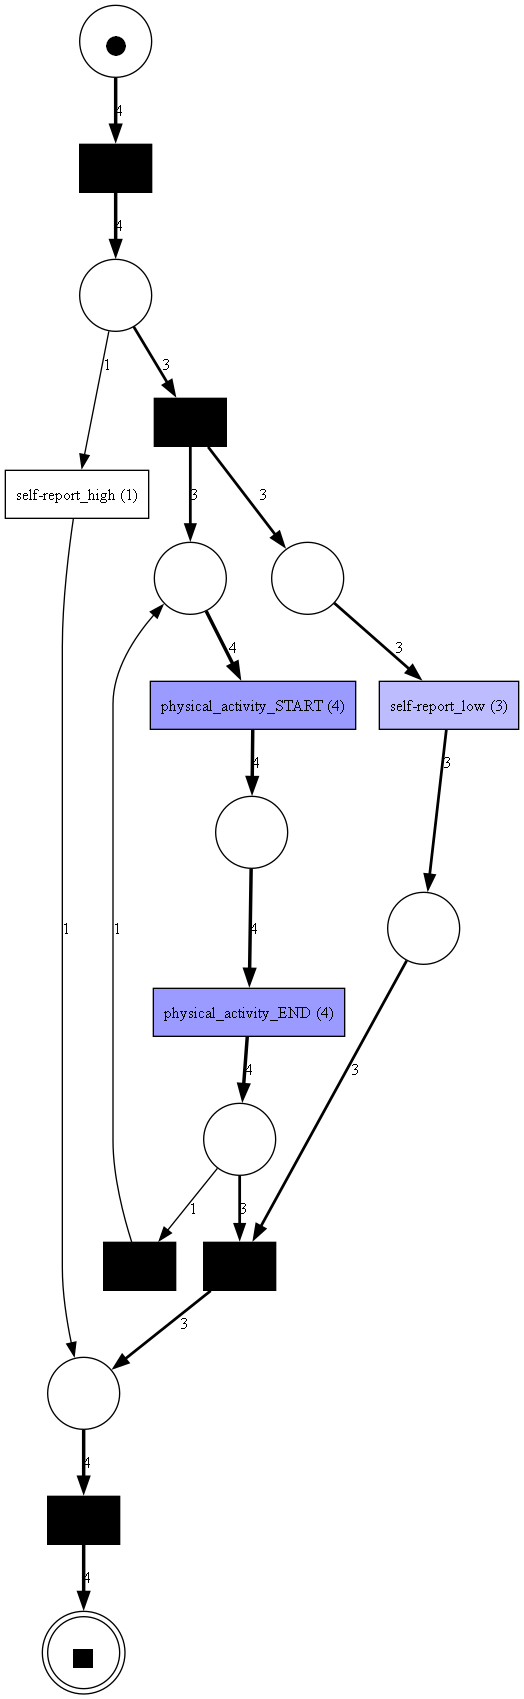

In [13]:
# Visualizing
# For frequency-based visualization
parameters = {
    pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png",
    pn_visualizer.Variants.FREQUENCY.value.Parameters.DEBUG: False,
    pn_visualizer.Variants.FREQUENCY.value.Parameters.RANKDIR: "TB"
}
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                          variant=pn_visualizer.Variants.FREQUENCY,
                          parameters=parameters,
                          log=event_log)
pn_visualizer.view(gviz)

Petri net with time statistics

In [11]:
# Convert process tree to Petri net
# For performance-based visualization (showing time statistics)
# Convert timestamps if they're not in datetime format
if isinstance(event_log[0][0]['time:timestamp'], str):
    for trace in event_log:
        for event in trace:
            event['time:timestamp'] = pd.to_datetime(event['time:timestamp'])


parameters = {
    pn_visualizer.Variants.PERFORMANCE.value.Parameters.FORMAT: "png",
    pn_visualizer.Variants.PERFORMANCE.value.Parameters.DEBUG: False,
    pn_visualizer.Variants.PERFORMANCE.value.Parameters.RANKDIR: "TB",
    pn_visualizer.Variants.PERFORMANCE.value.Parameters.AGGREGATION_MEASURE: "mean",  # or "median", "min", "max"
    pn_visualizer.Variants.PERFORMANCE.value.Parameters.ACTIVITY_KEY: "concept:name",
    pn_visualizer.Variants.PERFORMANCE.value.Parameters.TIMESTAMP_KEY: "time:timestamp"
}
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                          variant=pn_visualizer.Variants.PERFORMANCE,
                          parameters=parameters,
                          log=event_log)

replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

In [12]:
pn_visualizer.save(gviz, "petri_net_with_statistics.png")

''